In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import copy
import random
import pandas as pd
import math
import scipy
from scipy.stats import norm, expon
from scipy.linalg import null_space

import matplotlib as mpl

import os
cwd = os.getcwd()

In [4]:
#function n_state_model specifically used to plot the track with exact motion
def n_state_model_plot(delta_t, T, V, Lambda, P, sigma, x0=0.0, t0=0.0, state='?', seed=1223):
    """
    Simulates axonal transport
    delta_t = time step (s) 8nm / 800nm/s = 0.01s
    T = total time (s)
    
    #all velocities (with sign)   
    V = [v_1, v_2, ..., v_n] # here indexed 0,1,...,n-1
    
    # rates time spent on state i
    Lambda = [lambda_1, lambda_2, ..., lambda_n] = (lambda_i) # here indexed 0,1,...,n-1
    
    # transition matrix: p_ij probability of switching from i to j
    P = (p_ij)            
    
    sigma #noise std
    
    x0 = initial position
    state = initial state known or '?'
    seed = select random seed
    """
    # set a random seed
    np.random.seed(seed)
    random.seed(seed)
    
    if delta_t<=0 or T<delta_t:
        print('Error defining time')
        return None
    
    n = Lambda.shape[0]
    
    if np.any(Lambda <= np.zeros(n)):
        print('Error defining lambdas')
        return None
    
    if n!=P.shape[0] or n!=P.shape[1] or n!=V.shape[0]:
        print('Error with dimensions')
        return None
    
    if np.any(np.diag(P) != np.zeros(n)):
        print('Error defining transition matrix P diag')
        return None
        
    if np.any(np.sum(P, axis=1) != np.ones(n)):
        print('Error defining transition matrix P sum')
        return None
    
    if np.any(sigma < 0):
        print('Error defining noise parameter sigma')
        return None
        
    t = [t0]
    x = [x0]
    curr_dt = 0
    curr_dx = 0

    #Building Q transpose
    Q = np.zeros((n,n))
    for i in range(n):
        for j in range(0,i):
            Q[i,j] = Lambda[i]*P[i,j]
        Q[i,i] = -Lambda[i]
        for j in range(i+1,n):
            Q[i,j] = Lambda[i]*P[i,j]
    Qt = Q.T
    
    #Computing w s.t. Q^T w = 0 and then P(st)
    W = null_space(Qt)
    P_st = W / np.sum(W)
    
    #Choosing an initial state
    if state=='?': #state -1 is unknown
        state = random.choices(np.arange(n), weights=P_st, k=1)[0]
        
    state_save = []
        
    while t[-1]<T: # T is in seconds again
        curr_dt = np.random.exponential(scale=1/Lambda[state])
        curr_dx = curr_dt*V[state]
        t.append(t[-1]+curr_dt)
        x.append(x[-1]+curr_dx)
        state_save.append(state)
        state = random.choices(np.arange(n), weights=P[state, :], k=1)[0]
    
    state_save.append(state)
    
    #CREATE delta_t=0.3 approx
    t_points = np.linspace(0, T, int(T/delta_t)+1) #e.g. 0, 0.3, 0.6, ..., 60
    #print(x,t)
    # generate error points
    x_points = np.zeros(t_points.shape)
    y_points = np.random.normal(loc=0, scale=sigma,
                                size=t_points.shape)
    switches = np.zeros(t_points.shape)
    state_it = state_save[0]
    all_states_save = [[] for i in range(int(T/delta_t)+1)]
    tauF_save = []
    tauB_save = []
    tauS_save = []
    
    j = 0
    p = np.polyfit(t[j:j+2], x[j:j+2], 1)
    for i in range(0,int(T/delta_t)+1):
        todo = True
        while todo:
            all_states_save[i].append(state_save[j])
            if t_points[i]>=t[j] and t_points[i]<=t[j+1]:
                x_points[i] += np.polyval(p, t_points[i])
                y_points[i] += x_points[i]
                todo = False
                
                if t_points[i]==t[j]:
                    if i!= 0:
                        switches[i] += 1
                    else:
                        print(0)
            else:
                j+=1
                switches[i] +=1
                p = np.polyfit(t[j:j+2], x[j:j+2], 1)
                

                
    return x, t, y_points, t_points

0


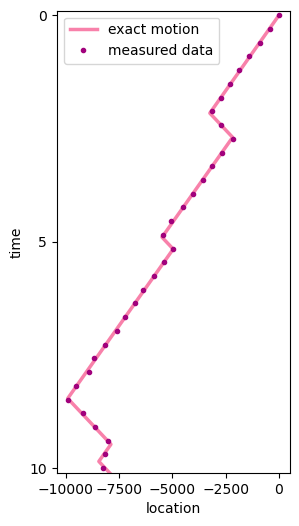

In [22]:
delta_t = 0.3 
T = 10
V = np.array([2000, -1500])
Lambda = np.array([1, 0.5])
P = np.array([[0.0, 1.0], [1.0, 0.0]])
sigma = 50
n = Lambda.shape[0]

x,t,y_points,t_points = n_state_model_plot(delta_t, T, V, Lambda, P, sigma, seed=2345)
#sw[0] should be ignored since it does not mean anything
colors_list = mpl.colormaps['RdPu'](np.linspace(0, 1, 10))

plt.figure(figsize=(3,6))
plt.plot(x, t, color=colors_list[-6], label=r'exact motion', linewidth=2.5, alpha=1)
plt.plot(y_points, t_points, '.', color=colors_list[-3], label=r'measured data', linewidth=1)
plt.ylim([-0.1, T+0.1])

plt.legend()
plt.gca().invert_yaxis()
plt.ylabel(r'time')
plt.xlabel('location')
plt.yticks([0, 5, 10])

plt.savefig("track.png", format="png", dpi=1200, bbox_inches="tight") 